In [1]:
import time
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from config import DEVICE, NUM_CLASSES, NUM_EPOCHS , OUT_DIR
from model import create_model
from utils import Averager
from datasets import train_loader, valid_loader,visualize_batch

/home/ubuntu/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of training samples: 155
Number of validation samples: 20



In [2]:
def train(train_data_loader, model):
    print('Training')
    global train_itr
    global train_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))

    for _, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data

        a_images = list(image.to(DEVICE) for image in images)
        a_targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        p_images = list(image.to(DEVICE) for image in images)
        p_targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        n_images = list(image.to(DEVICE) for image in images)
        n_targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        anchor = model(a_images, a_targets)
        positive = model(p_images, p_targets)
        negative = model(n_images, n_targets)

        anchor_loss = sum(loss for loss in anchor.values())
        positive_loss = sum(loss for loss in positive.values())
        negative_loss = sum(loss for loss in negative.values())

        losses = criterion(anchor_loss, positive_loss, negative_loss)
        loss_value = losses.item()
        train_loss_list.append(loss_value)

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()

        train_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [3]:
def validate(valid_data_loader, model):
    print('Validating')
    global val_itr
    global val_loss_list

    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))

    for _, data in enumerate(prog_bar):
        images, targets = data

        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            anchor_valid = model(images, targets)
            positive_valid = model(images, targets)
            negative_valid = model(images, targets)


        anchor_valid_loss = sum(loss for loss in anchor_valid.values())
        positive_valid_loss = sum(loss for loss in positive_valid.values())
        negative_valid_loss = sum(loss for loss in negative_valid.values())

        losses = criterion(anchor_valid_loss, positive_valid_loss, negative_valid_loss)
        loss_value = losses.item()
        val_loss_list.append(loss_value)

        val_loss_hist.send(loss_value)

        val_itr += 1

        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

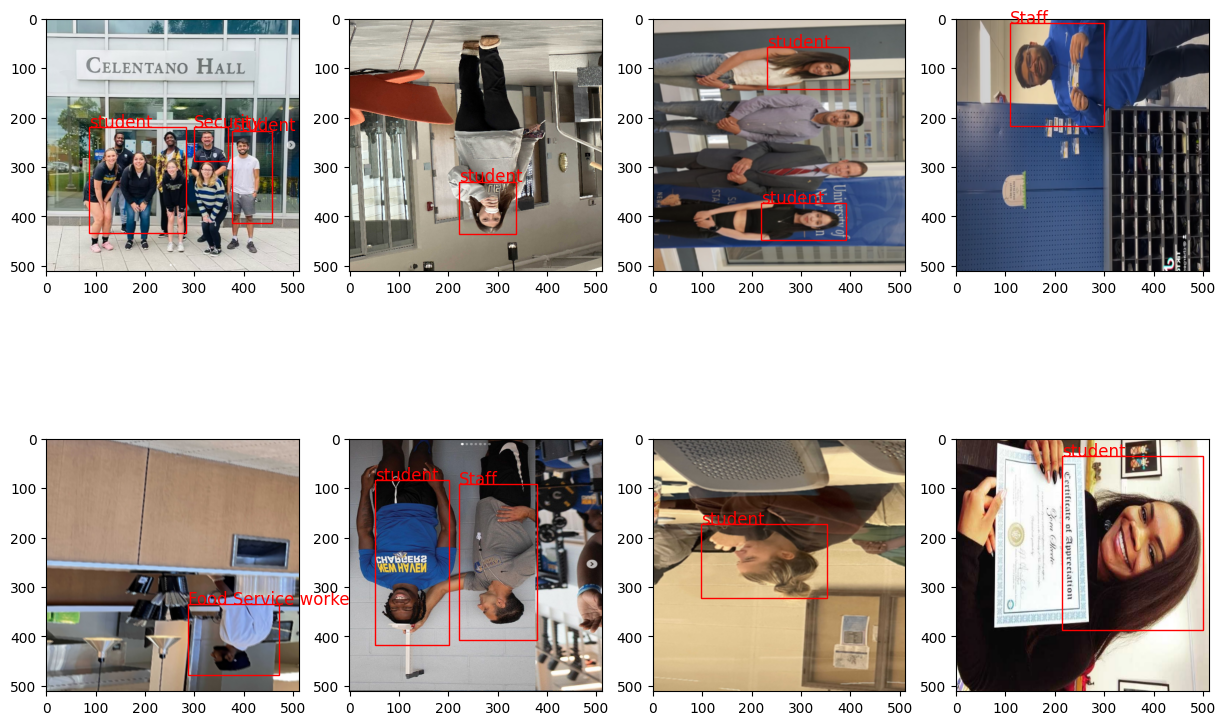

In [4]:
#Visualize batch of images

images, targets = next(iter(train_loader))

visualize_batch(images,targets)

In [5]:
# Model initialization and setup
model = create_model(num_classes=NUM_CLASSES).to(DEVICE)

# Get parameters that require gradient
params = [p for p in model.parameters() if p.requires_grad]

# Define loss function and optimizer
criterion = nn.TripletMarginWithDistanceLoss(distance_function=nn.PairwiseDistance(), margin=0.1, swap=True, reduction='none')
optimizer = torch.optim.SGD(params, lr=1e-5, momentum=0.7, weight_decay=5e-5)

# Initialize loss trackers
train_loss_hist = Averager()
val_loss_hist = Averager()

# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1

# Initialize loss lists
train_loss_list = []
val_loss_list = []

# Model name
MODEL_NAME = 'model'

# Training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset loss histories
    train_loss_hist.reset()
    val_loss_hist.reset()

    # Time the training and validation
    start = time.time()
    train_loss = train(train_loader, model)
    val_loss = validate(valid_loader, model)
    print(f"Epoch #{epoch} train loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch} validation loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")


training = 'done'


EPOCH 1 of 40
Training


Loss: 0.1170: 100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


Validating


Loss: 0.0904: 100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


Epoch #0 train loss: 0.102
Epoch #0 validation loss: 0.103
Took 0.543 minutes for epoch 0

EPOCH 2 of 40
Training


Loss: 0.1131: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


Validating


Loss: 0.1085: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #1 train loss: 0.101
Epoch #1 validation loss: 0.104
Took 0.509 minutes for epoch 1

EPOCH 3 of 40
Training


Loss: 0.1029: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.1037: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch #2 train loss: 0.102
Epoch #2 validation loss: 0.105
Took 0.506 minutes for epoch 2

EPOCH 4 of 40
Training


Loss: 0.1152: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.1019: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #3 train loss: 0.104
Epoch #3 validation loss: 0.102
Took 0.510 minutes for epoch 3

EPOCH 5 of 40
Training


Loss: 0.1068: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.1272: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #4 train loss: 0.102
Epoch #4 validation loss: 0.104
Took 0.508 minutes for epoch 4

EPOCH 6 of 40
Training


Loss: 0.1034: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Validating


Loss: 0.0807: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #5 train loss: 0.103
Epoch #5 validation loss: 0.098
Took 0.515 minutes for epoch 5

EPOCH 7 of 40
Training


Loss: 0.1115: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.1137: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #6 train loss: 0.105
Epoch #6 validation loss: 0.101
Took 0.513 minutes for epoch 6

EPOCH 8 of 40
Training


Loss: 0.1019: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.1156: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch #7 train loss: 0.103
Epoch #7 validation loss: 0.106
Took 0.511 minutes for epoch 7

EPOCH 9 of 40
Training


Loss: 0.1066: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.0956: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #8 train loss: 0.104
Epoch #8 validation loss: 0.102
Took 0.511 minutes for epoch 8

EPOCH 10 of 40
Training


Loss: 0.1147: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.0796: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #9 train loss: 0.106
Epoch #9 validation loss: 0.093
Took 0.513 minutes for epoch 9

EPOCH 11 of 40
Training


Loss: 0.1151: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.1037: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #10 train loss: 0.105
Epoch #10 validation loss: 0.098
Took 0.510 minutes for epoch 10

EPOCH 12 of 40
Training


Loss: 0.1058: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Validating


Loss: 0.1139: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #11 train loss: 0.102
Epoch #11 validation loss: 0.108
Took 0.514 minutes for epoch 11

EPOCH 13 of 40
Training


Loss: 0.1096: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


Validating


Loss: 0.1028: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #12 train loss: 0.102
Epoch #12 validation loss: 0.105
Took 0.510 minutes for epoch 12

EPOCH 14 of 40
Training


Loss: 0.0956: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1173: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #13 train loss: 0.103
Epoch #13 validation loss: 0.104
Took 0.505 minutes for epoch 13

EPOCH 15 of 40
Training


Loss: 0.1021: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.1399: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #14 train loss: 0.103
Epoch #14 validation loss: 0.116
Took 0.508 minutes for epoch 14

EPOCH 16 of 40
Training


Loss: 0.1064: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.0973: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #15 train loss: 0.101
Epoch #15 validation loss: 0.099
Took 0.511 minutes for epoch 15

EPOCH 17 of 40
Training


Loss: 0.1114: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.0855: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #16 train loss: 0.103
Epoch #16 validation loss: 0.101
Took 0.512 minutes for epoch 16

EPOCH 18 of 40
Training


Loss: 0.0999: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1020: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #17 train loss: 0.100
Epoch #17 validation loss: 0.101
Took 0.502 minutes for epoch 17

EPOCH 19 of 40
Training


Loss: 0.1178: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


Validating


Loss: 0.1303: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #18 train loss: 0.102
Epoch #18 validation loss: 0.115
Took 0.509 minutes for epoch 18

EPOCH 20 of 40
Training


Loss: 0.1000: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.0943: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch #19 train loss: 0.100
Epoch #19 validation loss: 0.101
Took 0.513 minutes for epoch 19

EPOCH 21 of 40
Training


Loss: 0.1030: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


Validating


Loss: 0.1019: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #20 train loss: 0.102
Epoch #20 validation loss: 0.101
Took 0.510 minutes for epoch 20

EPOCH 22 of 40
Training


Loss: 0.1167: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.0894: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #21 train loss: 0.104
Epoch #21 validation loss: 0.101
Took 0.511 minutes for epoch 21

EPOCH 23 of 40
Training


Loss: 0.1110: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1130: 100%|██████████| 3/3 [00:02<00:00,  1.24it/s]


Epoch #22 train loss: 0.102
Epoch #22 validation loss: 0.102
Took 0.503 minutes for epoch 22

EPOCH 24 of 40
Training


Loss: 0.0951: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1229: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #23 train loss: 0.102
Epoch #23 validation loss: 0.105
Took 0.505 minutes for epoch 23

EPOCH 25 of 40
Training


Loss: 0.1165: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1139: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #24 train loss: 0.104
Epoch #24 validation loss: 0.109
Took 0.505 minutes for epoch 24

EPOCH 26 of 40
Training


Loss: 0.1003: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1044: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #25 train loss: 0.105
Epoch #25 validation loss: 0.100
Took 0.505 minutes for epoch 25

EPOCH 27 of 40
Training


Loss: 0.0937: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1038: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #26 train loss: 0.101
Epoch #26 validation loss: 0.100
Took 0.504 minutes for epoch 26

EPOCH 28 of 40
Training


Loss: 0.1030: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Validating


Loss: 0.0779: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #27 train loss: 0.102
Epoch #27 validation loss: 0.089
Took 0.503 minutes for epoch 27

EPOCH 29 of 40
Training


Loss: 0.1128: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.1060: 100%|██████████| 3/3 [00:02<00:00,  1.25it/s]


Epoch #28 train loss: 0.103
Epoch #28 validation loss: 0.099
Took 0.506 minutes for epoch 28

EPOCH 30 of 40
Training


Loss: 0.1107: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1085: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #29 train loss: 0.106
Epoch #29 validation loss: 0.107
Took 0.505 minutes for epoch 29

EPOCH 31 of 40
Training


Loss: 0.1006: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1071: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #30 train loss: 0.102
Epoch #30 validation loss: 0.101
Took 0.504 minutes for epoch 30

EPOCH 32 of 40
Training


Loss: 0.1540: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


Validating


Loss: 0.1007: 100%|██████████| 3/3 [00:02<00:00,  1.22it/s]


Epoch #31 train loss: 0.105
Epoch #31 validation loss: 0.105
Took 0.507 minutes for epoch 31

EPOCH 33 of 40
Training


Loss: 0.0975: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


Validating


Loss: 0.1199: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #32 train loss: 0.104
Epoch #32 validation loss: 0.108
Took 0.510 minutes for epoch 32

EPOCH 34 of 40
Training


Loss: 0.0744: 100%|██████████| 20/20 [00:28<00:00,  1.40s/it]


Validating


Loss: 0.1036: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #33 train loss: 0.100
Epoch #33 validation loss: 0.098
Took 0.509 minutes for epoch 33

EPOCH 35 of 40
Training


Loss: 0.1204: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1039: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #34 train loss: 0.101
Epoch #34 validation loss: 0.105
Took 0.505 minutes for epoch 34

EPOCH 36 of 40
Training


Loss: 0.1135: 100%|██████████| 20/20 [00:27<00:00,  1.39s/it]


Validating


Loss: 0.1073: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #35 train loss: 0.102
Epoch #35 validation loss: 0.099
Took 0.506 minutes for epoch 35

EPOCH 37 of 40
Training


Loss: 0.1076: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Validating


Loss: 0.1036: 100%|██████████| 3/3 [00:02<00:00,  1.20it/s]


Epoch #36 train loss: 0.103
Epoch #36 validation loss: 0.105
Took 0.502 minutes for epoch 36

EPOCH 38 of 40
Training


Loss: 0.1118: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Validating


Loss: 0.1200: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #37 train loss: 0.103
Epoch #37 validation loss: 0.110
Took 0.503 minutes for epoch 37

EPOCH 39 of 40
Training


Loss: 0.1181: 100%|██████████| 20/20 [00:27<00:00,  1.38s/it]


Validating


Loss: 0.0958: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch #38 train loss: 0.104
Epoch #38 validation loss: 0.105
Took 0.503 minutes for epoch 38

EPOCH 40 of 40
Training


Loss: 0.1076: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


Validating


Loss: 0.1013: 100%|██████████| 3/3 [00:02<00:00,  1.19it/s]

Epoch #39 train loss: 0.105
Epoch #39 validation loss: 0.099
Took 0.514 minutes for epoch 39


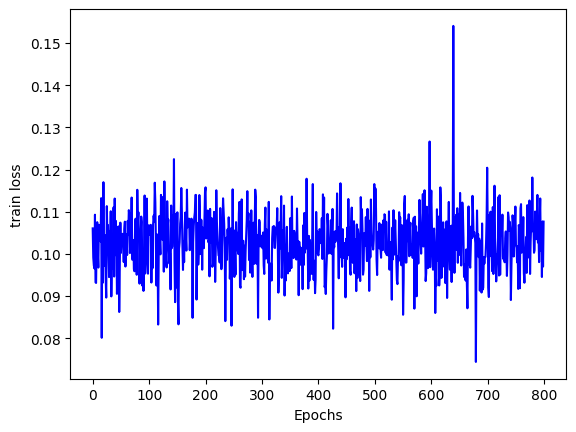

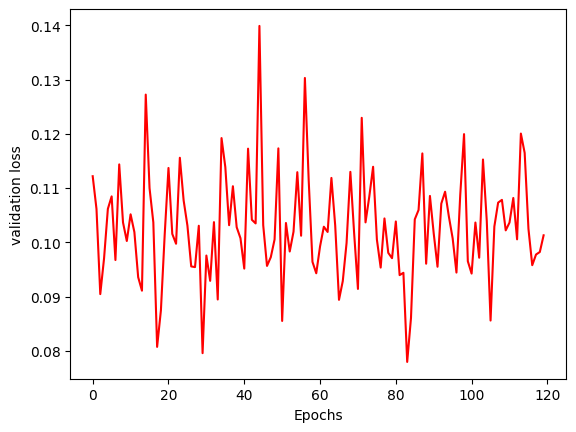

In [6]:


figure_1, train_ax = plt.subplots()
figure_2, valid_ax = plt.subplots()
# save the model and plots after training

if training == 'done': 
    train_ax.plot(train_loss, color='blue')
    train_ax.set_xlabel('Epochs')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='red')
    valid_ax.set_xlabel('Epochs')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{OUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUT_DIR}/valid_loss.png")

    torch.save(model.state_dict(), f"{OUT_DIR}/model.pth")